In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.manifold import LocallyLinearEmbedding
from scipy.fftpack import fft, ifft
from sklearn.decomposition import KernelPCA
from sklearn.manifold import Isomap

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs

In [ ]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
colab=1
import os

if colab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  working_dir='/content/drive/My Drive/Financial Programming/Project1/Qiuan'
  os.chdir(working_dir)

Mounted at /content/drive


# Plot DBSCAN

In [ ]:
# Plot the DBSCAN result of the data 
# Also print the labels and number of outliers
def plotDB(db, X, ticker, method):
    #db = DBSCAN(eps=2, min_samples =10).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype = bool)# a generalized np.seris
    core_samples_mask[db.core_sample_indices_] = True

    fig=plt.figure(figsize=(10,6))
    unique_labels = set(db.labels_)
    print(len(unique_labels),' labels: ', unique_labels)
    n_noise_ = list(db.labels_).count(-1)
    print('outliers: ', n_noise_)

    color_list = ['r', 'g', 'c', 'b', 'm', 'y','orange', 'k', 'tan', 'gold', 'navy', 'dimgray', 'darkred', 'olive', 
                  'pink', 'slateblue', 'lightseagreen', 'bisque', 'azure', 'thistle','r', 'g', 'c', 'b', 'm', 'y','orange', 'k', 'tan', 'gold', 'navy', 'dimgray', 'darkred', 'olive', 
                  'pink', 'slateblue', 'lightseagreen', 'bisque', 'azure', 'thistle']
    if len(unique_labels) > 40:
        unique_labels = sorted(unique_labels)[:20]
    for k in unique_labels:
        class_member_mask = (db.labels_ == k)
        
        xy = X[class_member_mask & core_samples_mask]
        
        plt.plot(xy[:, 0], xy[:,1], 'd', markerfacecolor = color_list[k], 
                markeredgecolor = 'w', markersize = 10, label = 'core points')
        
        xy2 = X[class_member_mask & ~core_samples_mask]
                
        if k == -1:
            plt.plot(xy2[:, 0], xy2[:,1], 's', markerfacecolor = 'lightblue',
                    markeredgecolor = 'b', markersize=8, label = 'outliers')
        else:
            plt.plot(xy2[:, 0], xy2[:,1], 'o', markerfacecolor = color_list[k], 
                    markeredgecolor = 'w', markersize = 10, label = 'reachable points')
                
        plt.legend()
    if method=='PCA':
        plt.xlabel('$PC_{1}$', fontsize=10)
        plt.ylabel('$PC_{2}$', fontsize=10)
    else:
        plt.xlabel('$'+ method +'_{1}'+'$', fontsize=8)
        plt.ylabel('$'+ method +'_{2}'+'$', fontsize=8)
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    plt.title('DBSCAN Clusters for %s data with %s' % (ticker, method))
    plt.grid(True, color = 'r', linestyle = ':', linewidth = 0.5)
    plt.show()


## Get MSE and Coverage Rate


In [ ]:
'''def calcuMse1(df,out_idx,true_markers_idx):
    #outliers=df['marketClose'].iloc[out_idx]
    #true_markers=df['marketClose'].iloc[true_markers_idx]
    y_predict=[]
    y=[]
    
    for i in out_idx:
      ans=False
      prev_j=true_markers_idx[0]
      for j in true_markers_idx:
        
        if(i==j):
          ans=True
          break
        
        if((prev_j<i)and(j>i)):
          break
        prev_j=j

        if(ans==True):
            y.append(df['close'][i])
            y_predict.append(df['close'][j])
        else:
            y.append(df['close'][i])
            y.append(df['close'][i])
            y_predict.append(df['close'][prev_j])
            y_predict.append(df['close'][j])

    y=np.asarray(y)
    y_predict=np.asarray(y_predict)
    mse=np.mean((y-y_predict)**2)
    print('MSE: ', mse)'''

import sys

def calcuMse1(df,out_idx,true_markers_idx):
    sum = 0
    for i in out_idx:
        intev = sys.maxsize
        keep_j = 0
        for j in true_markers_idx:
            if abs(i-j)<intev:
                intev = abs(i-j)
                keep_j = j        
        sum+= (df['close'][i] - df['close'][keep_j])**2
    result = sum/len(out_idx)
    print('MSE: ',result)
    
def dateToNumeric(df, idx):
    return [df.index.get_loc(i) for i in idx]

def calCoverageRate(out_idx, true_markers_idx):
    print('Coverage Rate: ',len(out_idx.intersection(true_markers_idx))/len(out_idx)) 


# Dimension Reduction

In [ ]:
class dimension_reduction:
    def __init__(self, ticker, df):
        self.ticker = ticker
        self.df = df
    
    def getPCA(self):
        scaler = StandardScaler()
        normalized_data = scaler.fit_transform(self.df)
        pca= PCA()
        self.pcaNewData = pca.fit_transform(normalized_data)
    
    def getTSNE(self, perplexity, init):
        normalized_data = MinMaxScaler().fit_transform(self.df)
        tsne = TSNE(perplexity = perplexity, init=init)
        self.tsneNewData = tsne.fit_transform(normalized_data)

    def getUMAP(self, n_neighbors, min_dist):
        self.umapNewData = umap.UMAP(n_neighbors = 30,
                       min_dist = 0.05,
                       metric = 'euclidean', 
                       init = 'random').fit_transform(StandardScaler().fit_transform(self.df))

    def getLLE(self, neighbors):
        normalized_data=StandardScaler().fit_transform(self.df)
        lle = LocallyLinearEmbedding(n_components=2, n_neighbors = neighbors)
        self.lleNewData = lle.fit_transform(normalized_data)

    def getKPCA(self):
        normalized_data=StandardScaler().fit_transform(self.df)
        kpca = KernelPCA(kernel='linear')
        self.kpcaNewData = kpca.fit_transform(normalized_data)

    def getISOM(self,neighbors):
        normalized_data=StandardScaler().fit_transform(self.df)
        isom = Isomap(n_components=2, n_neighbors=neighbors)
        self.isomNewData = isom.fit_transform(normalized_data)

    def fft_trans(self):
        df_trans = pd.DataFrame(fft(self.df).real, columns = self.df.columns)
        df_trans.index = self.df.index
        self.FFTNewData = df_trans
    
    def numOfGlobalMarkers(self):
        return np.count_nonzero(self.df['Marker'])

    def global_mask(self):
        return self.df['Marker']
    
    def fft_mask(self):
            self.fftRanking=self.FFTNewData.close.sort_values(ascending=False)[0:self.numOfGlobalMarkers()]
            return [idx in self.fftRanking.index for idx in self.df.index]
       

            


# Visualization

In [ ]:
# Plot trading markers for cryptocurrency data
def plotMarkers2(df,ticker, method, dr_mask, global_mask, fft_mask):
    plt.figure(figsize = (12, 6))
    plt.plot(df.index.values,df['close'], linewidth=1, alpha = 0.9, label = ticker)
    plt.scatter(df.index[dr_mask], df['close'][dr_mask], label=method+' Predicted Outlier',
                    marker='D', alpha = 0.9, color='r', s=50)
    plt.scatter(df.index[global_mask], df['close'][global_mask], label='Traditional Marker',
                    marker='*', alpha = 0.9, color='orange',  s=50)
    plt.scatter(df.index[fft_mask], df['close'][fft_mask], label='FFT Marker',
                    marker='*', alpha = 0.9, color='k',s=50)
    plt.legend()
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Price', fontsize=10)

# Cryptocurrency data preprocessing

In [ ]:
crypt_data=pd.read_csv('ETHUSD-5m-data.csv',index_col=0, parse_dates=True)
crypt_df = crypt_data.iloc[1:].copy()
crypt_df=crypt_df.drop(['symbol'], axis = 1)
crypt_df = crypt_df.fillna(0)
crypt_df['closeOfHigh'] = (crypt_df['high']-crypt_df['close'])/(crypt_df['high'] - crypt_df['low'])
crypt_df['pseudoVolatility'] = (crypt_df['high']-crypt_df['low'])/crypt_df['open']
crypt_df["closeOfHigh"] = crypt_df["closeOfHigh"].fillna(0)
crypt_df["pseudoVolatility"] = crypt_df["pseudoVolatility"].fillna(0)
crypt_df['Marker'] = abs(crypt_df['close']/crypt_df['close'].shift(1)-1)>= 0.005

crypt_df.head()

,close,foreignNotional,high,homeNotional,lastSize,low,open,trades,turnover,volume,vwap,closeOfHigh,pseudoVolatility,Marker
timestamp,,,,,,,,,,,,,,
2018-08-02 09:10:00+00:00,435.5,9.583905,435.5,0.022901,1.0,400.00,400.0,3,125550.0,3,418.50,0.000000,0.088750,False
2018-08-02 09:15:00+00:00,416.0,6239.761320,425.0,14.840168,89.0,406.05,435.5,25,81738315.0,1944,420.47,0.474934,0.043513,True
2018-08-02 09:20:00+00:00,422.4,21120.219630,422.9,49.996751,50.0,418.00,416.0,32,276608380.0,6548,422.44,0.102041,0.011779,True
2018-08-02 09:25:00+00:00,421.8,3446.779613,422.4,8.174452,10.0,421.30,422.4,10,45159000.0,1071,421.66,0.545455,0.002604,False
2018-08-02 09:30:00+00:00,422.2,24509.853650,422.3,58.124026,30.0,420.00,421.8,65,320436145.0,7599,421.69,0.043478,0.005453,False


In [ ]:
# Seperate the Cryptocurrency data into 4 parts
crypt_df_lst = [crypt_df.iloc[:36000],
                crypt_df.iloc[36001:72000],
                crypt_df.iloc[72001:104000],
                crypt_df.iloc[104001:]]
     
#crypt0 = dimension_reduction('ETHUSD_1',crypt_df[1:50000])

crypt1 = dimension_reduction('ETHUSD_1',crypt_df_lst[0])
crypt2 = dimension_reduction('ETHUSD_2',crypt_df_lst[1])
crypt3 = dimension_reduction('ETHUSD_3',crypt_df_lst[2])
crypt4 = dimension_reduction('ETHUSD_4',crypt_df_lst[3])
#crypt5 = dimension_reduction('ETHUSD_5',crypt_df_lst[4])
#crypt6 = dimension_reduction('ETHUSD_6',crypt_df_lst[5])

#crypt0_global_mask = crypt_df.iloc[1:50000]['Marker']

crypt1_global_mask = crypt_df_lst[0]['Marker']
crypt2_global_mask = crypt_df_lst[1]['Marker']
crypt3_global_mask = crypt_df_lst[2]['Marker']
crypt4_global_mask = crypt_df_lst[3]['Marker']
#crypt5_global_mask = crypt_df_lst[4]['Marker']
#crypt6_global_mask = crypt_df_lst[5]['Marker']

In [ ]:
print(crypt_df_lst[0]['Marker'][crypt_df_lst[0]['Marker']==True])
print(crypt_df_lst[1]['Marker'][crypt_df_lst[1]['Marker']==True])
print(crypt_df_lst[2]['Marker'][crypt_df_lst[2]['Marker']==True])
print(crypt_df_lst[3]['Marker'][crypt_df_lst[3]['Marker']==True])

timestamp
2018-08-02 09:15:00+00:00    True
2018-08-02 09:20:00+00:00    True
2018-08-02 09:50:00+00:00    True
2018-08-02 10:00:00+00:00    True
2018-08-02 10:10:00+00:00    True
                             ... 
2018-12-04 15:05:00+00:00    True
2018-12-04 17:10:00+00:00    True
2018-12-05 02:05:00+00:00    True
2018-12-05 03:00:00+00:00    True
2018-12-05 04:15:00+00:00    True
Name: Marker, Length: 2584, dtype: bool
timestamp
2018-12-05 14:00:00+00:00    True
2018-12-05 16:20:00+00:00    True
2018-12-05 16:50:00+00:00    True
2018-12-05 16:55:00+00:00    True
2018-12-05 23:40:00+00:00    True
                             ... 
2019-04-08 21:05:00+00:00    True
2019-04-08 22:30:00+00:00    True
2019-04-09 02:05:00+00:00    True
2019-04-09 05:10:00+00:00    True
2019-04-09 08:30:00+00:00    True
Name: Marker, Length: 2021, dtype: bool
timestamp
2019-04-09 10:25:00+00:00    True
2019-04-10 00:25:00+00:00    True
2019-04-10 01:30:00+00:00    True
2019-04-10 06:00:00+00:00    True
2019-0

In [ ]:
# get fft transform

crypt1.fft_trans()
crypt2.fft_trans()
crypt3.fft_trans()
crypt4.fft_trans()
#crypt5.fft_trans()
#crypt6.fft_trans()

## PCA Analysis

8  labels:  {0, 1, 2, 3, 4, 5, 6, -1}
outliers:  511


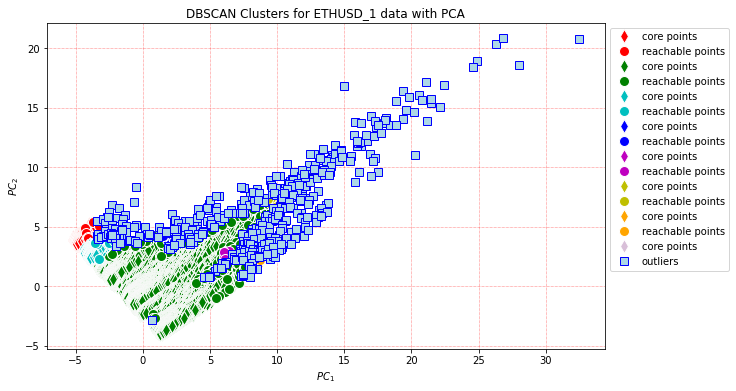

In [ ]:
crypt1.getPCA()
crypt1.pcaNewData = crypt1.pcaNewData[:,:2]
crypt1_pca_db = DBSCAN(eps=0.3, min_samples =10).fit(crypt1.pcaNewData)
plotDB(crypt1_pca_db,crypt1.pcaNewData, crypt1.ticker, 'PCA')

10  labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, -1}
outliers:  942


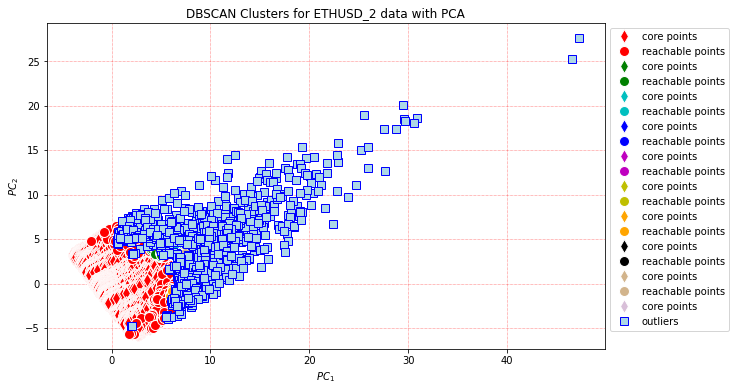

In [ ]:
crypt2.getPCA()
crypt2.pcaNewData = crypt2.pcaNewData[:,:2]
crypt2_pca_db = DBSCAN(eps=0.3, min_samples =10).fit(crypt2.pcaNewData)
plotDB(crypt2_pca_db,crypt2.pcaNewData, crypt2.ticker, 'PCA')

13  labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, -1}
outliers:  761


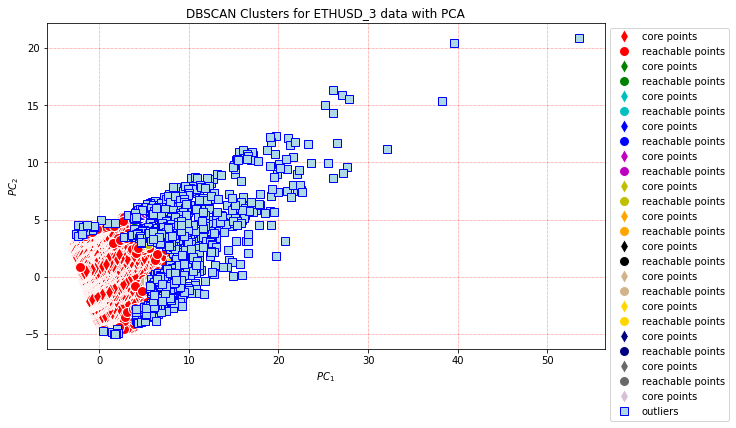

In [ ]:
crypt3.getPCA()
crypt3.pcaNewData = crypt3.pcaNewData[:,:2]
crypt3_pca_db = DBSCAN(eps=0.3, min_samples =10).fit(crypt3.pcaNewData)
plotDB(crypt3_pca_db,crypt3.pcaNewData, crypt3.ticker, 'PCA')

7  labels:  {0, 1, 2, 3, 4, 5, -1}
outliers:  959


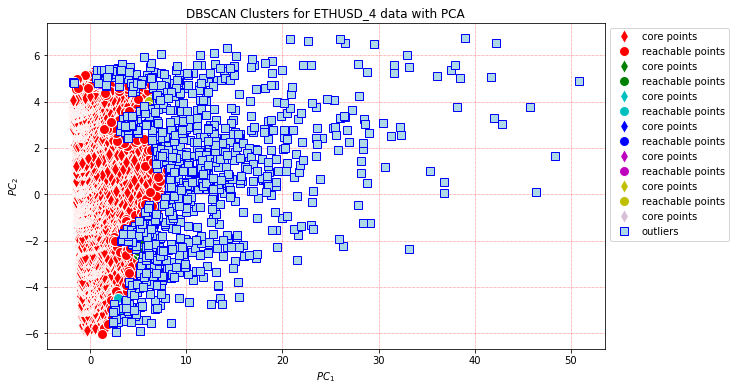

In [ ]:
crypt4.getPCA()
crypt4.pcaNewData = crypt4.pcaNewData[:,:2]
crypt4_pca_db = DBSCAN(eps=0.3, min_samples =10).fit(crypt4.pcaNewData)
plotDB(crypt4_pca_db,crypt4.pcaNewData, crypt4.ticker, 'PCA')

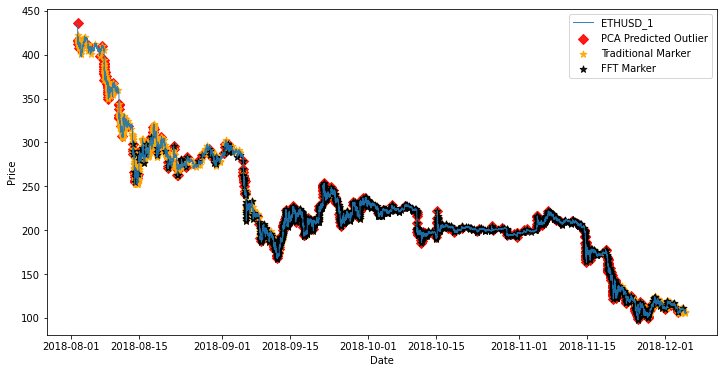

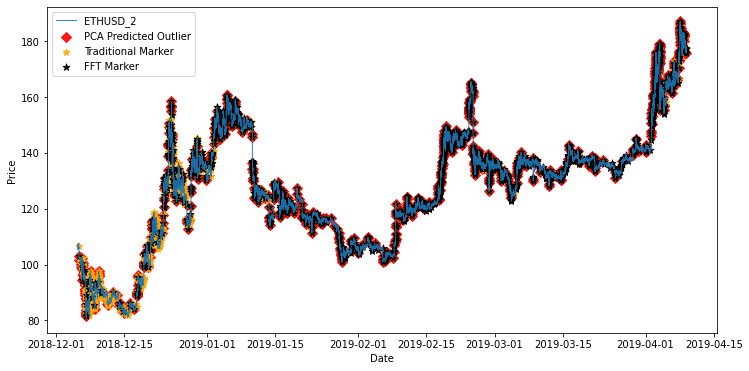

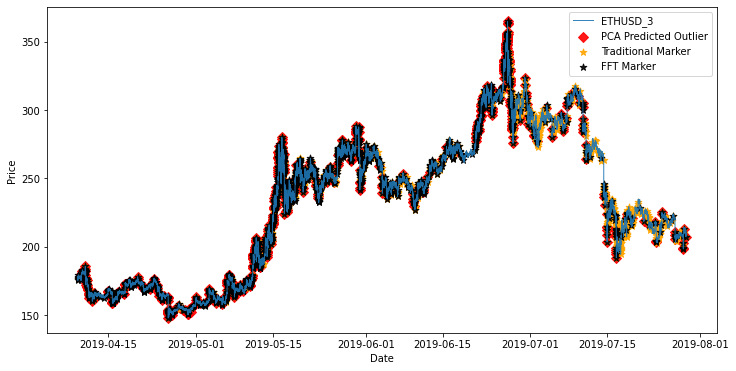

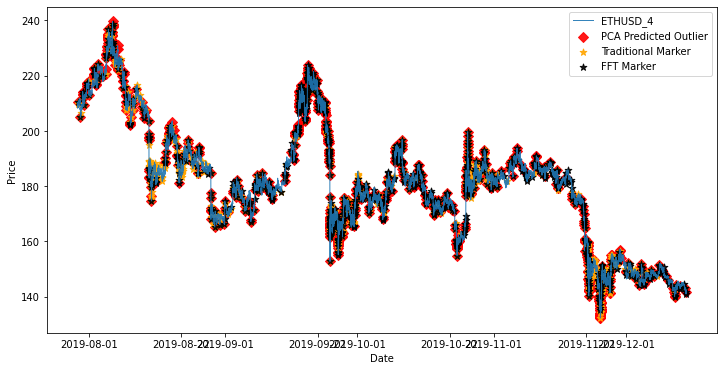

In [ ]:
crypt1_pca_mask = crypt1_pca_db.labels_==-1
crypt2_pca_mask = crypt2_pca_db.labels_==-1
crypt3_pca_mask = crypt3_pca_db.labels_==-1
crypt4_pca_mask = crypt4_pca_db.labels_==-1

plotMarkers2(crypt_df_lst[0], crypt1.ticker, 'PCA', crypt1_pca_mask, crypt1_global_mask, crypt1.fft_mask())
plotMarkers2(crypt_df_lst[1], crypt2.ticker, 'PCA', crypt2_pca_mask, crypt2_global_mask,crypt2.fft_mask())
plotMarkers2(crypt_df_lst[2], crypt3.ticker, 'PCA', crypt3_pca_mask, crypt3_global_mask,crypt3.fft_mask())
plotMarkers2(crypt_df_lst[3], crypt4.ticker, 'PCA', crypt4_pca_mask, crypt4_global_mask,crypt4.fft_mask())


In [ ]:
crypt1_truemarker = crypt1.fftRanking.index | crypt_df_lst[0][crypt_df_lst[0]['Marker'] == True].index
print('Crypt1 pca:')
calcuMse1(crypt_df_lst[0], dateToNumeric(crypt_df_lst[0],crypt_df_lst[0][crypt1_pca_mask].index), 
          dateToNumeric(crypt_df_lst[0], crypt1_truemarker))
calCoverageRate(crypt_df_lst[0][crypt1_pca_mask].index,crypt1_truemarker)

Crypt1 pca:
MSE:  0.8073336594911936
Coverage Rate:  0.9843444227005871


In [ ]:
crypt2_truemarker = crypt2.fftRanking.index | crypt_df_lst[1][crypt_df_lst[1]['Marker'] == True].index

print('Crypt2 pca:')
calcuMse1(crypt_df_lst[1], dateToNumeric(crypt_df_lst[1],crypt_df_lst[1][crypt2_pca_mask].index), 
          dateToNumeric(crypt_df_lst[1], crypt2_truemarker))
calCoverageRate(crypt_df_lst[1][crypt2_pca_mask].index,crypt2_truemarker)

Crypt2 pca:
MSE:  0.0061889596602972274
Coverage Rate:  0.9819532908704883


In [ ]:
crypt3_truemarker = crypt3.fftRanking.index | crypt_df_lst[2][crypt_df_lst[2]['Marker'] == True].index

print('Crypt3 pca:')
calcuMse1(crypt_df_lst[2], dateToNumeric(crypt_df_lst[2],crypt_df_lst[2][crypt3_pca_mask].index), 
          dateToNumeric(crypt_df_lst[2], crypt3_truemarker))
calCoverageRate(crypt_df_lst[2][crypt3_pca_mask].index,crypt3_truemarker)

Crypt3 pca:
MSE:  0.0990670170827849
Coverage Rate:  0.9605781865965834


In [ ]:
crypt4_truemarker = crypt4.fftRanking.index | crypt_df_lst[3][crypt_df_lst[3]['Marker'] == True].index

print('Crypt4 pca:')
calcuMse1(crypt_df_lst[3], dateToNumeric(crypt_df_lst[3],crypt_df_lst[3][crypt4_pca_mask].index), 
          dateToNumeric(crypt_df_lst[3], crypt4_truemarker))
calCoverageRate(crypt_df_lst[3][crypt4_pca_mask].index,crypt4_truemarker)

Crypt4 pca:
MSE:  0.3630917622523462
Coverage Rate:  0.8873826903023984


## UMAP Analysis

43  labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, -1}
outliers:  118


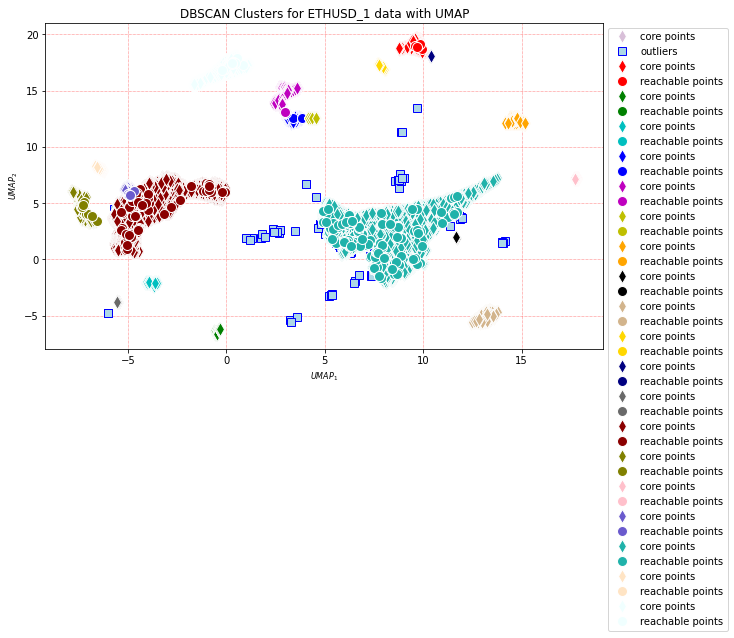

In [ ]:
crypt1.getUMAP(100, 0.3)
crypt1.umapNewData = crypt1.umapNewData[:,:2]
crypt1_umap_db = DBSCAN(eps=0.15, min_samples =10).fit(crypt1.umapNewData)
plotDB(crypt1_umap_db,crypt1.umapNewData, crypt1.ticker, 'UMAP')

32  labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, -1}
outliers:  332


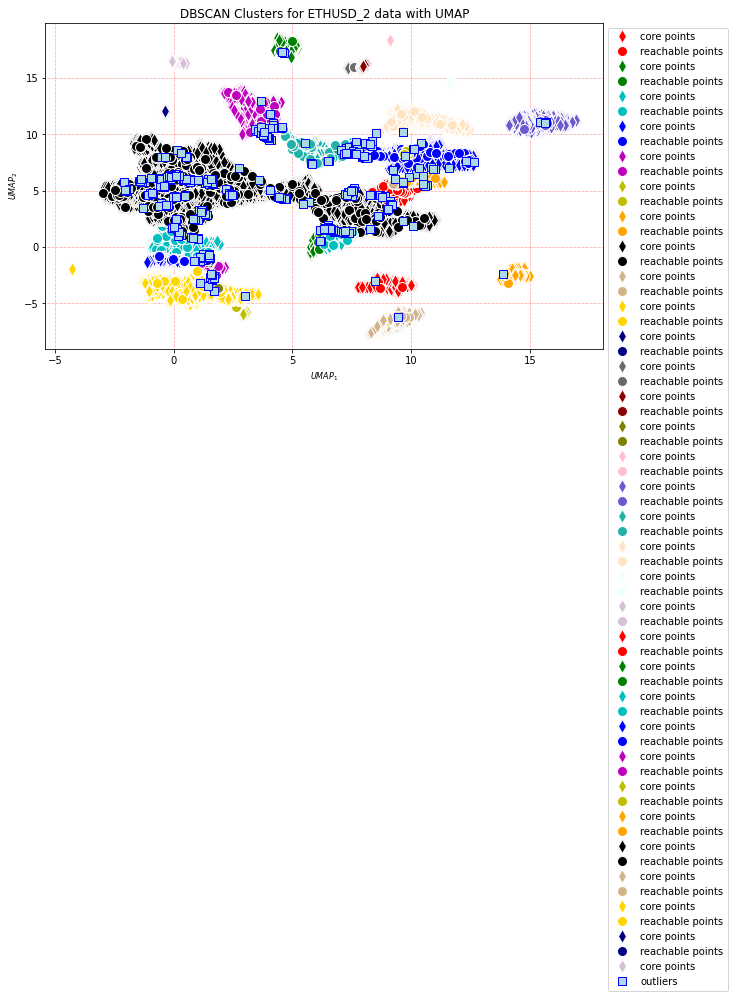

In [ ]:
crypt2.getUMAP(100, 0.3)
crypt2.umapNewData = crypt2.umapNewData[:,:2]
crypt2_umap_db = DBSCAN(eps=0.15, min_samples =10).fit(crypt2.umapNewData)
plotDB(crypt2_umap_db,crypt2.umapNewData, crypt2.ticker, 'UMAP')

In [ ]:
crypt3.getUMAP(100, 0.3)
crypt3.umapNewData = crypt3.umapNewData[:,:2]
crypt3_umap_db = DBSCAN(eps=0.15, min_samples =10).fit(crypt3.umapNewData)
plotDB(crypt3_umap_db,crypt3.umapNewData, crypt3.ticker, 'UMAP')

In [ ]:
crypt4.getUMAP(100, 0.3)
crypt4.umapNewData = crypt4.umapNewData[:,:2]
crypt4_umap_db = DBSCAN(eps=0.15, min_samples =10).fit(crypt4.umapNewData)
plotDB(crypt4_umap_db,crypt4.umapNewData, crypt4.ticker, 'UMAP')

In [ ]:
crypt1_umap_mask = crypt1_umap_db.labels_==-1
crypt2_umap_mask = crypt2_umap_db.labels_==-1
crypt3_umap_mask = crypt3_umap_db.labels_==-1
crypt4_umap_mask = crypt4_umap_db.labels_==-1

plotMarkers2(crypt_df_lst[0], crypt1.ticker, 'UMAP', crypt1_umap_mask, crypt1_global_mask, crypt1.fft_mask())
plotMarkers2(crypt_df_lst[1], crypt2.ticker, 'UMAP', crypt2_umap_mask, crypt2_global_mask,crypt2.fft_mask())
plotMarkers2(crypt_df_lst[2], crypt3.ticker, 'UMAP', crypt3_umap_mask, crypt3_global_mask,crypt3.fft_mask())
plotMarkers2(crypt_df_lst[3], crypt4.ticker, 'UMAP', crypt4_umap_mask, crypt4_global_mask,crypt4.fft_mask())


In [ ]:
print('Crypt1 umap:')
calcuMse1(crypt_df_lst[0], dateToNumeric(crypt_df_lst[0],crypt_df_lst[0][crypt1_umap_mask].index), 
          dateToNumeric(crypt_df_lst[0], crypt1_truemarker))
calCoverageRate(crypt_df_lst[0][crypt1_umap_mask].index, crypt1_truemarker)
#crypt_df_lst[0][crypt_df_lst[0]['Marker'] == True].index

In [ ]:
print('Crypt2 umap:')
calcuMse1(crypt_df_lst[1], dateToNumeric(crypt_df_lst[1],crypt_df_lst[1][crypt2_umap_mask].index), 
          dateToNumeric(crypt_df_lst[1], crypt2_truemarker))
calCoverageRate(crypt_df_lst[1][crypt2_umap_mask].index, crypt2_truemarker)


In [ ]:
print('Crypt3 umap:')
calcuMse1(crypt_df_lst[2], dateToNumeric(crypt_df_lst[2],crypt_df_lst[2][crypt3_umap_mask].index), 
          dateToNumeric(crypt_df_lst[2], crypt3_truemarker))
calCoverageRate(crypt_df_lst[2][crypt3_umap_mask].index, crypt3_truemarker)


In [ ]:
print('Crypt4 umap:')
calcuMse1(crypt_df_lst[3], dateToNumeric(crypt_df_lst[3],crypt_df_lst[3][crypt4_umap_mask].index), 
          dateToNumeric(crypt_df_lst[3], crypt4_truemarker))
calCoverageRate(crypt_df_lst[3][crypt4_umap_mask].index, crypt4_truemarker)


## LLE Analysis

23  labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, -1}
outliers:  124


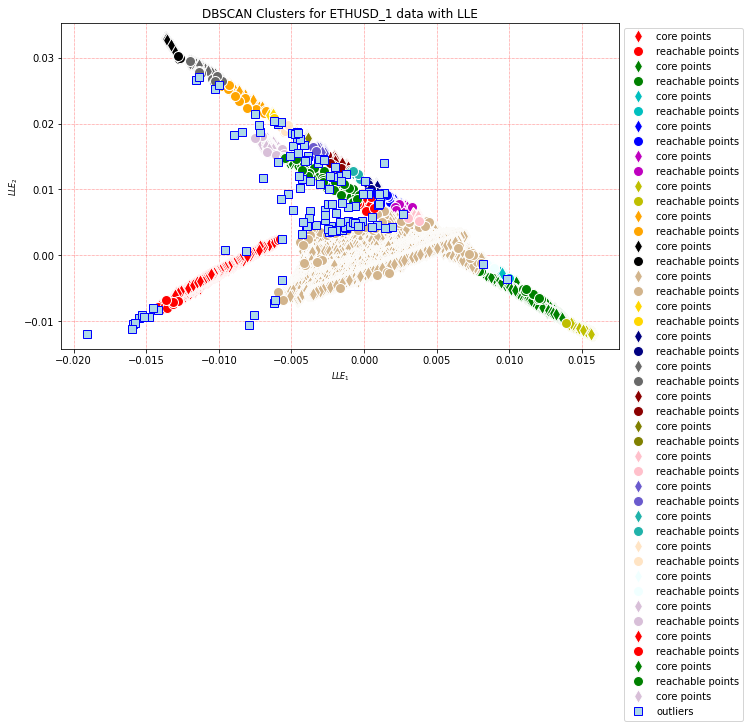

In [ ]:
crypt1.getLLE(50)
crypt1.lleNewData = crypt1.lleNewData[:,:2]
crypt1_lle_db = DBSCAN(eps=0.0005, min_samples =10).fit(crypt1.lleNewData)
plotDB(crypt1_lle_db,crypt1.lleNewData, crypt1.ticker, 'LLE')

In [ ]:
crypt2.getLLE(50)
crypt2.lleNewData = crypt2.lleNewData[:,:2]
crypt2_lle_db = DBSCAN(eps=0.0005, min_samples =10).fit(crypt2.lleNewData)
plotDB(crypt2_lle_db,crypt2.lleNewData, crypt2.ticker, 'LLE')

In [ ]:
crypt3.getLLE(50)
crypt3.lleNewData = crypt3.lleNewData[:,:2]
crypt3_lle_db = DBSCAN(eps=0.0005, min_samples =10).fit(crypt3.lleNewData)
plotDB(crypt3_lle_db,crypt3.lleNewData, crypt3.ticker, 'LLE')

In [ ]:
crypt4.getLLE(60)
crypt4.lleNewData = crypt4.lleNewData[:,:2]
crypt4_lle_db = DBSCAN(eps=0.0005, min_samples =10).fit(crypt4.lleNewData)
plotDB(crypt4_lle_db,crypt4.lleNewData, crypt4.ticker, 'LLE')

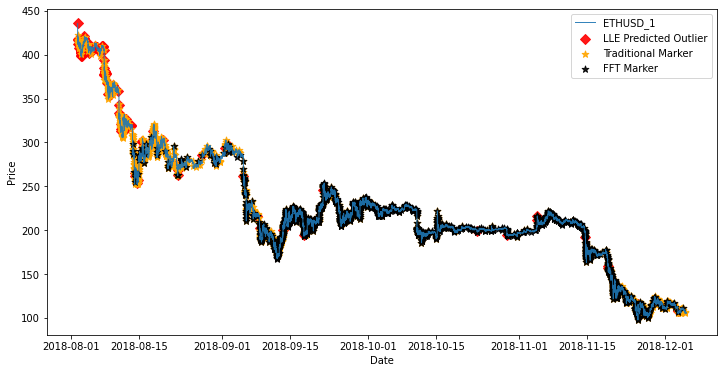

In [ ]:
crypt1_lle_mask = crypt1_lle_db.labels_==-1
crypt2_lle_mask = crypt2_lle_db.labels_==-1
crypt3_lle_mask = crypt3_lle_db.labels_==-1
crypt4_lle_mask = crypt4_lle_db.labels_==-1

plotMarkers2(crypt_df_lst[0], crypt1.ticker, 'LLE', crypt1_lle_mask, crypt1_global_mask, crypt1.fft_mask())
plotMarkers2(crypt_df_lst[1], crypt2.ticker, 'LLE', crypt2_lle_mask, crypt2_global_mask,crypt2.fft_mask())
plotMarkers2(crypt_df_lst[2], crypt3.ticker, 'LLE', crypt3_lle_mask, crypt3_global_mask,crypt3.fft_mask())
plotMarkers2(crypt_df_lst[3], crypt4.ticker, 'LLE', crypt4_lle_mask, crypt4_global_mask,crypt4.fft_mask())


In [ ]:
print('Crypt1 LLE:')
calcuMse1(crypt_df_lst[0], dateToNumeric(crypt_df_lst[0],crypt_df_lst[0][crypt1_lle_mask].index), 
          dateToNumeric(crypt_df_lst[0], crypt1_truemarker))
calCoverageRate(crypt_df_lst[0][crypt1_lle_mask].index, crypt1_truemarker)


Crypt1 LLE:
MSE:  10.489576612903234
Coverage Rate:  0.18548387096774194


In [ ]:
print('Crypt2 LLE:')
calcuMse1(crypt_df_lst[1], dateToNumeric(crypt_df_lst[1],crypt_df_lst[1][crypt2_lle_mask].index), 
          dateToNumeric(crypt_df_lst[1], crypt2_truemarker))
calCoverageRate(crypt_df_lst[1][crypt2_lle_mask].index, crypt2_truemarker)


In [ ]:
print('Crypt3 LLE:')
calcuMse1(crypt_df_lst[2], dateToNumeric(crypt_df_lst[2],crypt_df_lst[2][crypt3_lle_mask].index), 
          dateToNumeric(crypt_df_lst[2], crypt3_truemarker))
calCoverageRate(crypt_df_lst[2][crypt3_lle_mask].index, crypt3_truemarker)


In [ ]:
print('Crypt4 LLE:')
calcuMse1(crypt_df_lst[3], dateToNumeric(crypt_df_lst[3],crypt_df_lst[3][crypt4_lle_mask].index), 
          dateToNumeric(crypt_df_lst[3], crypt4_truemarker))
calCoverageRate(crypt_df_lst[3][crypt4_lle_mask].index, crypt4_truemarker)


## TSNE Analysis

In [ ]:
crypt1.getTSNE(200, 'pca')
crypt1.tsneNewData = crypt1.tsneNewData[:,:2]
crypt1_tsne_db = DBSCAN(eps=0.9, min_samples =10).fit(crypt1.tsneNewData)
plotDB(crypt1_tsne_db,crypt1.tsneNewData, crypt1.ticker, 'TSNE')

In [ ]:
crypt2.getTSNE(200, 'pca')
crypt2.tsneNewData = crypt2.tsneNewData[:,:2]
crypt2_tsne_db = DBSCAN(eps=0.9, min_samples =10).fit(crypt2.tsneNewData)
plotDB(crypt2_tsne_db,crypt2.tsneNewData, crypt2.ticker, 'TSNE')

In [ ]:
crypt3.getTSNE(200, 'pca')
crypt3.tsneNewData = crypt3.tsneNewData[:,:2]
crypt3_tsne_db = DBSCAN(eps=0.9, min_samples =10).fit(crypt3.tsneNewData)
plotDB(crypt3_tsne_db,crypt3.tsneNewData, crypt3.ticker, 'TSNE')

34  labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, -1}
outliers:  409


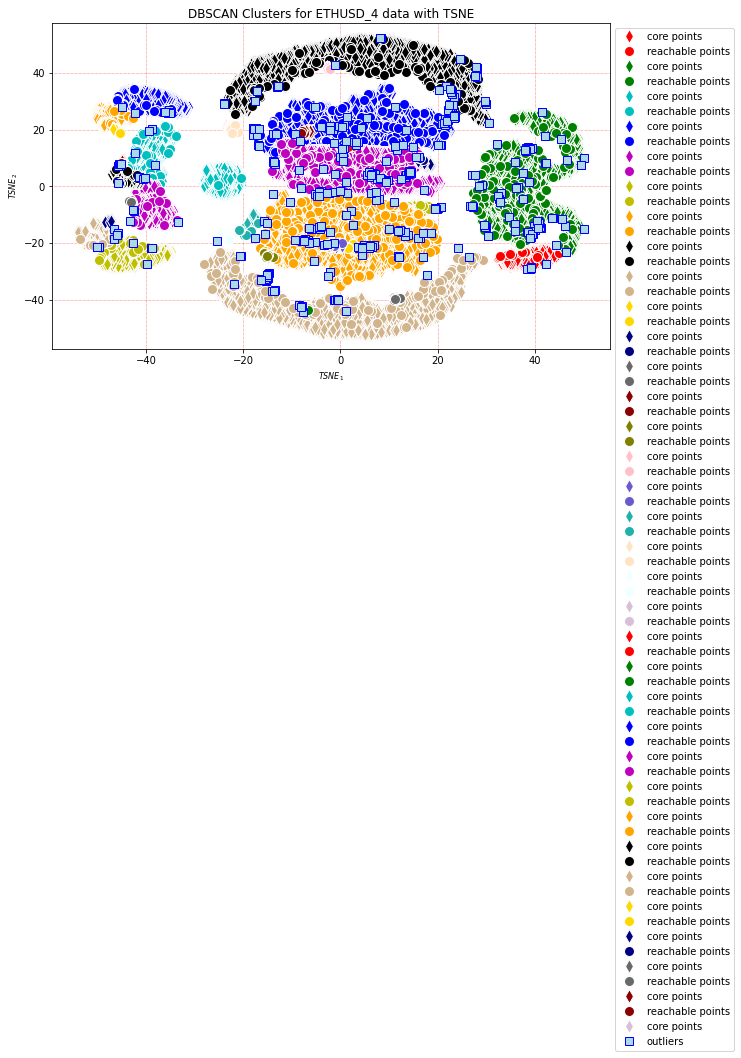

In [ ]:
crypt4.getTSNE(200, 'pca')
crypt4.tsneNewData = crypt4.tsneNewData[:,:2]
crypt4_tsne_db = DBSCAN(eps=0.9, min_samples =10).fit(crypt4.tsneNewData)
plotDB(crypt4_tsne_db,crypt4.tsneNewData, crypt4.ticker, 'TSNE')

In [ ]:
crypt1_tsne_mask = crypt1_tsne_db.labels_==-1
crypt2_tsne_mask = crypt2_tsne_db.labels_==-1
crypt3_tsne_mask = crypt3_tsne_db.labels_==-1
crypt4_tsne_mask = crypt4_tsne_db.labels_==-1

plotMarkers2(crypt_df_lst[0], crypt1.ticker, 'TSNE', crypt1_tsne_mask, crypt1_global_mask, crypt1.fft_mask())
plotMarkers2(crypt_df_lst[1], crypt2.ticker, 'TSNE', crypt2_tsne_mask, crypt2_global_mask,crypt2.fft_mask())
plotMarkers2(crypt_df_lst[2], crypt3.ticker, 'TSNE', crypt3_tsne_mask, crypt3_global_mask,crypt3.fft_mask())
plotMarkers2(crypt_df_lst[3], crypt4.ticker, 'TSNE', crypt4_tsne_mask, crypt4_global_mask,crypt4.fft_mask())


In [ ]:
print('Crypt1 TSNE:')
calcuMse1(crypt_df_lst[0], dateToNumeric(crypt_df_lst[0],crypt_df_lst[0][crypt1_tsne_mask].index), 
          dateToNumeric(crypt_df_lst[0], crypt1_truemarker))
calCoverageRate(crypt_df_lst[0][crypt1_tsne_mask].index, crypt1_truemarker)


In [ ]:
print('Crypt2 TSNE:')
calcuMse1(crypt_df_lst[1], dateToNumeric(crypt_df_lst[1],crypt_df_lst[1][crypt2_tsne_mask].index), 
          dateToNumeric(crypt_df_lst[1], crypt2_truemarker))
calCoverageRate(crypt_df_lst[1][crypt2_tsne_mask].index, crypt2_truemarker)


In [ ]:
print('Crypt3 TSNE:')
calcuMse1(crypt_df_lst[2], dateToNumeric(crypt_df_lst[2],crypt_df_lst[2][crypt3_tsne_mask].index), 
          dateToNumeric(crypt_df_lst[2], crypt3_truemarker))
calCoverageRate(crypt_df_lst[2][crypt3_tsne_mask].index, crypt3_truemarker)


In [ ]:
print('Crypt4 TSNE:')
calcuMse1(crypt_df_lst[3], dateToNumeric(crypt_df_lst[3],crypt_df_lst[3][crypt4_tsne_mask].index), 
          dateToNumeric(crypt_df_lst[3], crypt4_truemarker))
calCoverageRate(crypt_df_lst[3][crypt4_tsne_mask].index, crypt4_truemarker)
